In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader
from utils.networks_2 import *
from utils.data import Loader32
import torch.optim as optim
from tqdm import tqdm
from utils.metrics import plot_tsne
from utils.create_data import simple_plot

[Papier](https://arxiv.org/pdf/1907.06673.pdf)

On entraîne le modèle sur les log returns:

$ LogReturn_t = log(S_t) - log (S_{t-1}) $

Modèle pas conditionnel, celui ci génère des une série de rendements (127 ici) sans prendre en compte le passé mais simplement en s'étant entrainé sur une série de 2500 observations.

In [2]:
num_epochs = 100
nz = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 0.0002

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev) 
device

device(type='cuda', index=0)

In [3]:
df = pd.read_csv('./data/GANData.csv')
actif = "UK Government Bond - USD Hedged"
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
y.shape

(2494,)

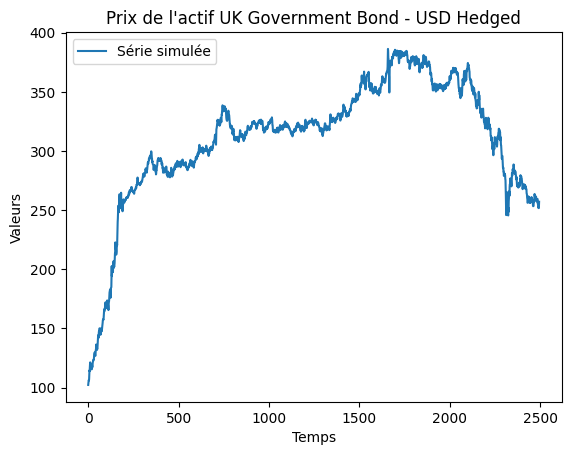

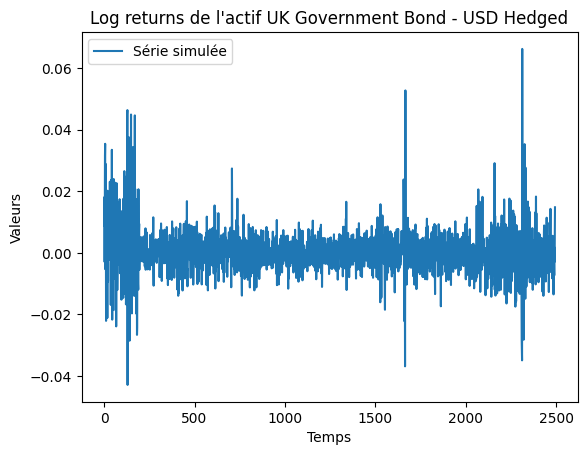

In [7]:
simple_plot(true_y, f"Prix de l'actif {actif}")
simple_plot(y, f"Log returns de l'actif {actif}")

In [10]:
num_epochs = 200
generator = Generator().to(device)
log_returns_preprocessed = y#np.expand_dims(y, axis=1)
train = True
dict_loss = {"Gen" : [], "Disc": []}
if train:
    discriminator = Discriminator(seq_len).to(device)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

    dataset = Loader32(log_returns_preprocessed, 127)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    dataset = Loader32(log_returns_preprocessed, 1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    t = tqdm(range(num_epochs))
    for epoch in t:
        list_loss_G = []
        list_loss_D = []
        for idx, data in enumerate(dataloader, 0):

            discriminator.zero_grad()
            real = data.to(device)
            batch_size, seq_len = real.size(0), real.size(1)
            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake = generator(noise).detach()
            disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0:
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(noise)))
                gen_loss.backward()
                gen_optimizer.step() 
                list_loss_G.append(gen_loss.item())
                list_loss_D.append(disc_loss.item())
        dict_loss['Gen'].append(np.mean(list_loss_G))
        dict_loss['Disc'].append(np.mean(list_loss_D))
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    #torch.save(generator, f'{generator_path}trained_generator_{file_name}_epoch_{epoch}.pth')

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()


/home/onyxia/work/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
  0%|          | 0/200 [00:00<?, ?it/s]

Discriminator Loss: 0.00000018 Generator Loss: -0.49868900: 100%|██████████| 200/200 [03:22<00:00,  1.01s/it] 


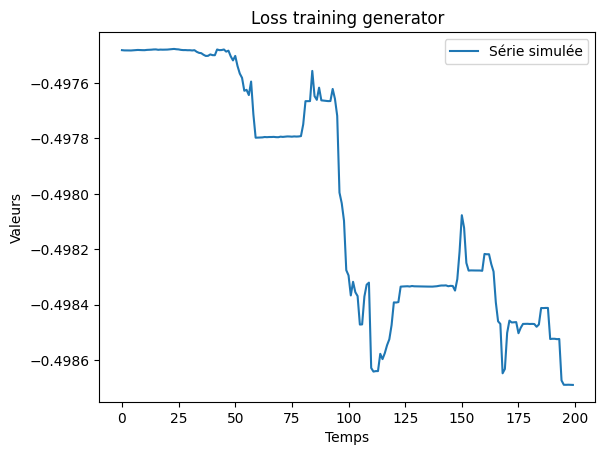

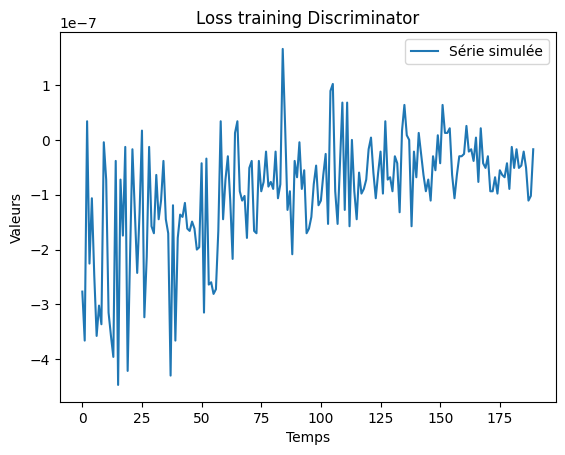

In [125]:
simple_plot(dict_loss['Gen'], 'Loss training generator')
simple_plot(dict_loss['Disc'][10:], 'Loss training Discriminator')

In [11]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
z = generator(noise).cpu().detach().squeeze()

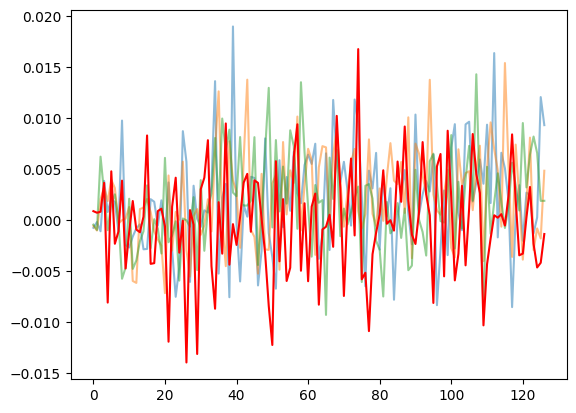

In [129]:
from utils.create_data import simple_plot
generator.eval()
noise = torch.randn(80,3,127).to(device)
z = generator(noise).cpu().detach().squeeze()
for i in range(3):
    plt.plot(z.numpy()[i]/20, alpha=0.5 ,label= f'scénario {i}')
n = random.randint(0, 2000)
plt.plot(y[n:n+127], color='red')

In [17]:
def moving_window(x, length):
    return [x[i: i+ length] for i in range(0,(len(x)+1)-length, 10)]
augment_data= np.array(moving_window(y,127))

In [18]:
real = np.reshape(augment_data, (237,1,127))
idx = np.random.randint(augment_data.shape[0], size=80)
real_samples = real[idx,:,:]

In [88]:
fake = np.reshape(z.numpy()/10, (80,1,127))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 240 samples in 0.001s...
[t-SNE] Computed neighbors for 240 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 240 / 240
[t-SNE] Mean sigma: 0.039516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.638706
[t-SNE] KL divergence after 300 iterations: 0.678022


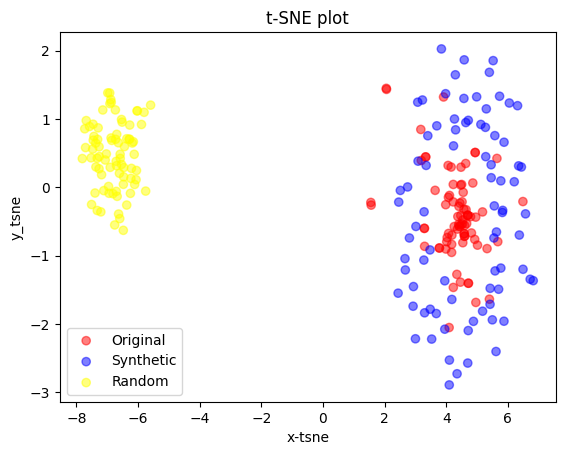

In [94]:
plot_tsne(real_samples, fake, random=True)

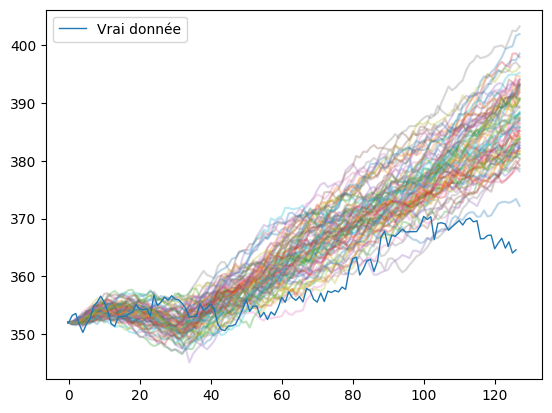

In [141]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
z = generator(noise).cpu().detach().squeeze()
fake = np.reshape(z.numpy(), (80,1,127))
def fake_scenarios(input_, fake_array, start, num,alpha=0.5, reducer=5):
    if fake_array.shape[1]==1:
        fake_array = np.squeeze(fake_array)
    if num>fake_array.shape[0]:
        num = fake_array.shape[0]
    for j in range(num):
        fake_line = np.array([true_y[start]] + [true_y[start] * np.prod(1 + fake_squeeze[j,:i+1]/reducer) for i in range(fake_squeeze.shape[1])])
        plt.plot(fake_line, alpha=alpha)
    plt.plot(input_[start:start+fake_array.shape[1]], linewidth=1, label='Vrai donnée')
    plt.legend()
    plt.show()

fake_scenarios(true_y, fake, random.randint(0, 2000), 6000, reducer=5, alpha=0.3)


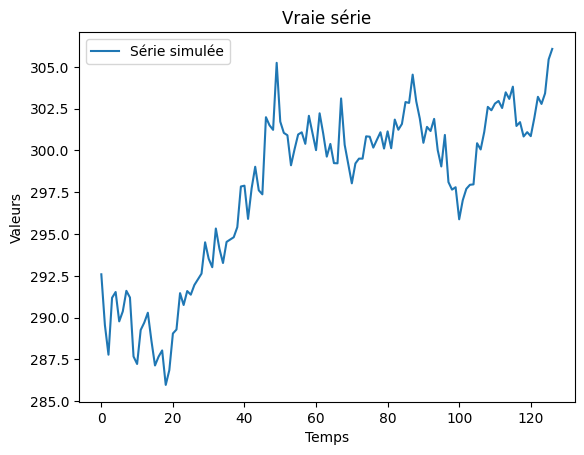

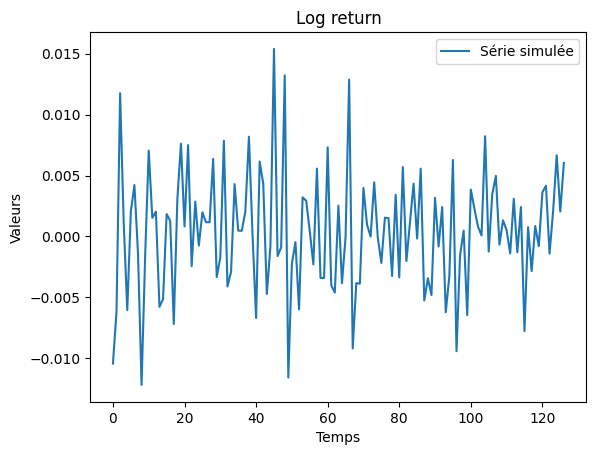

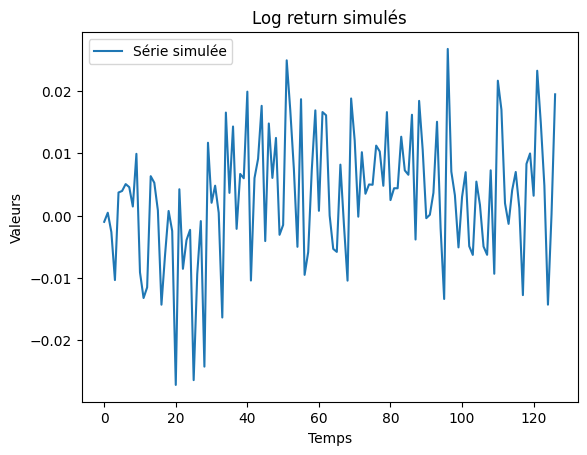

In [146]:
n = random.randint(0, 2000)
noise = torch.randn(1,3,127).to(device)
z = generator(noise).cpu().detach().squeeze().numpy()/10

simple_plot(true_y[n:n+127], "Vraie série")
simple_plot(y[n:n+127], "Log return")
simple_plot(z, 'Log return simulés')